In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar la base de datos archivo CSV.'
df = pd.read_csv('/content/datos.csv', delimiter=';')

# Verificación y limpieza básica de datos
# Aquí puedes añadir pasos para tratar valores faltantes o corregir errores
print(df.head())

   Unnamed: 0 Descripcion_Area_Rural   Furips_Descripcion        Ciudad  \
0           0                  RURAL  se estrelló de novi  BARRANQUILLA   
1           1                  RURAL  se estrelló de novi  BARRANQUILLA   
2           2                  RURAL  se estrelló de novi  BARRANQUILLA   
3           3                  RURAL  se estrelló de novi  BARRANQUILLA   
4           4                  RURAL  se estrelló de novi  BARRANQUILLA   

  Marca_Vehiculo Estado_Vehiculo_Descripcion Tipo_Vehiculo_Descripcion  \
0        reanaul                   Asegurado                Particular   
1        reanaul                   Asegurado                Particular   
2        reanaul                   Asegurado                Particular   
3        reanaul                   Asegurado                Particular   
4        reanaul                   Asegurado                Particular   

  Tipo_Vehiculo Condicion_Accidentado_Descripcion  \
0     Automovil                          Ocupante  

In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')

# Preprocesamiento de texto  para LDA
def preprocess_text(text):
    result = []
    lemmatizer = WordNetLemmatizer()
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            # Lematización con POS Tag (simplificado)
            lemma = lemmatizer.lemmatize(token, pos="v")
            result.append(lemma)
    return result

# Columnas de interés
df['text_for_lda'] = df['Furips_Descripcion'].astype(str) + ' ' + df['Categoria_Descripcion_Eje10'].astype(str)
documents = df['text_for_lda'].map(preprocess_text)

dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

# Configuración de hiperparámetros
num_topics = 44 # Ajuste basado en pruebas anteriores o criterio
alpha = 'asymmetric'  # Permite variabilidad en la distribución de temas por documentos
beta = 0.01  # Baja para concentrar palabras por tema

lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=40, workers=2, alpha=alpha, eta=beta)

# Convertir los documentos a vectores de temas usando el modelo LDA ajustado
ldafeatures = [lda_model[doc] for doc in corpus]
lda_features_matrix = np.array([[dict(doc).get(i, 0) for i in range(num_topics)] for doc in ldafeatures])




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install pyldavis
!pip install pandas


from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
import pickle
import pyLDAvis


topics = lda_model.show_topics(formatted=False, num_topics=30)

# Aquí, 'processed_docs' debe ser la lista de documentos después de todo el preprocesamiento.
coherence_model_lda = CoherenceModel(model=lda_model,  dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherencia de los temas (C_V):', coherence_lda)

# Busqueda de métricas
coherence_model_lda_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda_umass = coherence_model_lda_umass.get_coherence()
print('Coherencia de los temas (U_Mass):', coherence_lda_umass)

# Visualizar los temas
for topic_num, topic_words in topics[:15]:  # Limitar a 10 temas para simplificar
    print('\nTopic:', topic_num)
    print('Words:', [word for word, _ in topic_words])

# Visualización interactiva con pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

# Visualizar la distribución de temas en documentos seleccionados
for i in range(15):  # Mejorado para mostrar 15 documentos
    doc_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_probs = {topic: round(prob, 4) for topic, prob in doc_topics}
    print('\nDocumento', i, 'Distribución de Temas:', topic_probs)




Coherencia de los temas (C_V): 0.33496690840412774
Coherencia de los temas (U_Mass): -4.391272182815057

Topic: 43
Words: ['placa', 'resultando', 'cayendo', 'movilizaba', 'publica', 'pavimento', 'inesperadamente', 'cuando', 'curva', 'traumatismo']

Topic: 42
Words: ['conductora', 'lesionada', 'motocicleta', 'placas', 'resulta', 'cuando', 'pavimento', 'publica', 'colisionada', 'inesperadamente']

Topic: 41
Words: ['quien', 'conductor', 'motocicleta', 'movilizaba', 'cayendo', 'resultando', 'publica', 'pavimento', 'traumatismo', 'lesionado']

Topic: 40
Words: ['desplazaba', 'resulta', 'publica', 'motocicleta', 'placas', 'cuando', 'inesperadamente', 'conductor', 'traumatismo', 'lesionado']

Topic: 39
Words: ['otros', 'especificados', 'traumatismos', 'lesionado', 'torax', 'transporte', 'accidentes', 'pavimento', 'inesperadamente', 'motociclista']

Topic: 38
Words: ['sufre', 'falla', 'mecanica', 'llanta', 'sufrir', 'fallas', 'golpea', 'microsueño', 'bordillo', 'tropieza']

Topic: 37
Words: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


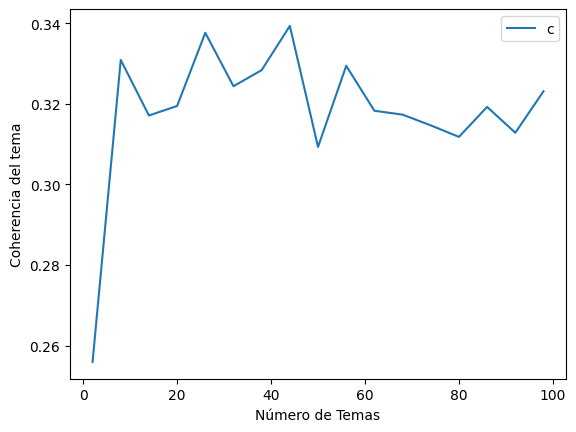

Número óptimo de temas: 44


In [ ]:
import numpy as np
import gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Función para maximizar coherencia
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2, alpha='asymmetric', eta=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Definir el rango para el número de temas
topic_limit = 100
topic_start = 2
topic_step = 6

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=topic_start, limit=topic_limit, step=topic_step)

# Graficar
x = range(topic_start, topic_limit, topic_step)
plt.plot(x, coherence_values)
plt.xlabel("Número de Temas")
plt.ylabel("Coherencia del tema")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Imprimir el número óptimo de temas
optimal_index = coherence_values.index(max(coherence_values))
optimal_num_topics = x[optimal_index]
print("Número óptimo de temas:", optimal_num_topics)
